In [55]:
# Importing
import theano.tensor as T
import sys, os
sys.path.append("/home/bl3/PycharmProjects/GeMpy/GeMpy")
sys.path.append("/home/bl3/PycharmProjects/pygeomod/pygeomod")
sys.path.append("/home/miguel/PycharmProjects/GeMpy/GeMpy")
import GeoMig

import importlib
importlib.reload(GeoMig)
import numpy as np
import pandas as pn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)

#%matplotlib inline
%matplotlib notebook

# Sandstone Model

First we make a GeMpy instance with most of the parameters default (except range that is given by the project). Then we also fix the extension and the resolution of the domain we want to interpolate. Finally we compile the function, only needed once every time we open the project (the guys of theano they are working on letting loading compiled files, even though in our case it is not a big deal).

*General note. So far the reescaling factor is calculated for all series at the same time. GeoModeller does it individually for every potential field. I have to look better what this parameter exactly means*

In [60]:
# Setting extend, grid and compile
# Setting the extent
sandstone = GeoMig.Interpolator(696000,747000,6863000,6950000,-20000, 2000,
                                range_var = np.float32(110000),
                               u_grade = 9) # Range used in geomodeller

# Setting resolution of the grid
sandstone.set_resolutions(40,40,80)
sandstone.create_regular_grid_3D()

# Compiling
sandstone.theano_compilation_3D()

/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


## Loading data from geomodeller

So there are 3 series, 2 of one single layer and 1 with 2. Therefore we need 3 potential fields, so lets begin.

In [61]:
sandstone.load_data_csv("foliations", os.pardir+"/input_data/a_Foliations.csv")
sandstone.load_data_csv("interfaces", os.pardir+"/input_data/a_Points.csv")
pn.set_option('display.max_rows', 25)
sandstone.Foliations;

### Defining Series

In [62]:
sandstone.set_series({"EarlyGranite_Series":sandstone.formations[-1], 
                      "BIF_Series":(sandstone.formations[0], sandstone.formations[1]),
                      "SimpleMafic_Series":sandstone.formations[2]}, 
                       order = ["EarlyGranite_Series",
                              "BIF_Series",
                              "SimpleMafic_Series"]) 
sandstone.series

,EarlyGranite_Series,BIF_Series,SimpleMafic_Series
0,EarlyGranite,SimpleMafic2,SimpleMafic1
1,EarlyGranite,SimpleBIF,SimpleMafic1


##  Early granite

The serie formations are EarlyGranite


<IPython.core.display.Javascript object>


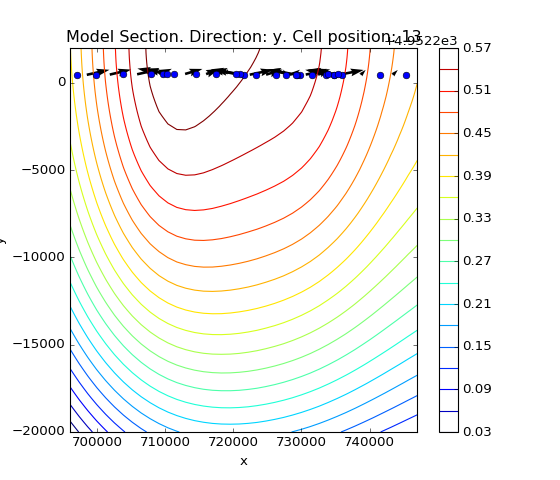

In [63]:
sandstone.compute_potential_field("EarlyGranite_Series", verbose = 1)
sandstone.plot_potential_field_2D(direction = "y", cell_pos = 13, figsize=(7,6), contour_lines = 20)

In [9]:
sandstone.potential_interfaces;

<IPython.core.display.Javascript object>


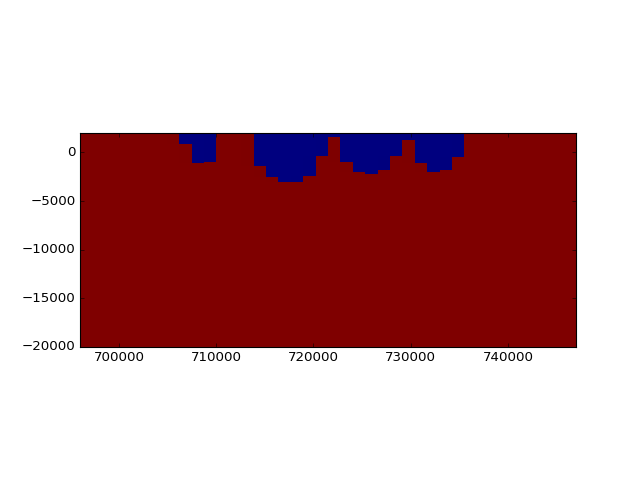

In [6]:
%matplotlib qt4
block = np.ones_like(sandstone.Z_x)
block[sandstone.Z_x>sandstone.potential_interfaces[0]] = 0
block[sandstone.Z_x<sandstone.potential_interfaces[-1]] = 1
block = block.reshape(40,40,150)
#block = np.swapaxes(block, 0, 1)
plt.imshow(block[:,8,:].T, origin = "bottom", aspect = "equal", extent = (sandstone.xmin, sandstone.xmax,
                                                                           sandstone.zmin, sandstone.zmax),
           interpolation = "none")

## BIF Series

The serie formations are SimpleMafic2|SimpleBIF


<IPython.core.display.Javascript object>


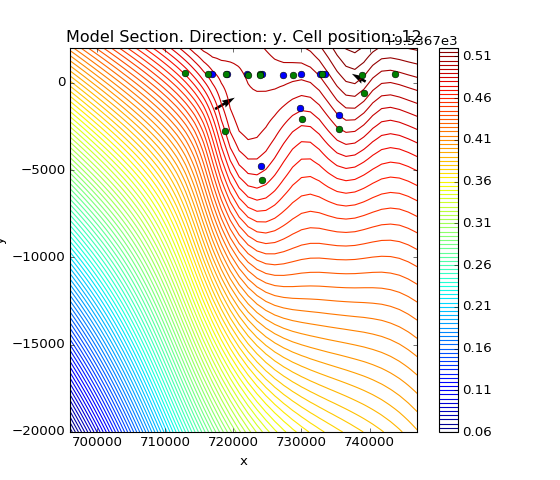

In [7]:
sandstone.compute_potential_field("BIF_Series", verbose=1)
sandstone.plot_potential_field_2D(direction = "y", cell_pos = 12, figsize=(7,6), contour_lines = 100)

In [178]:
sandstone.potential_interfaces, sandstone.layers[0].shape;

<IPython.core.display.Javascript object>


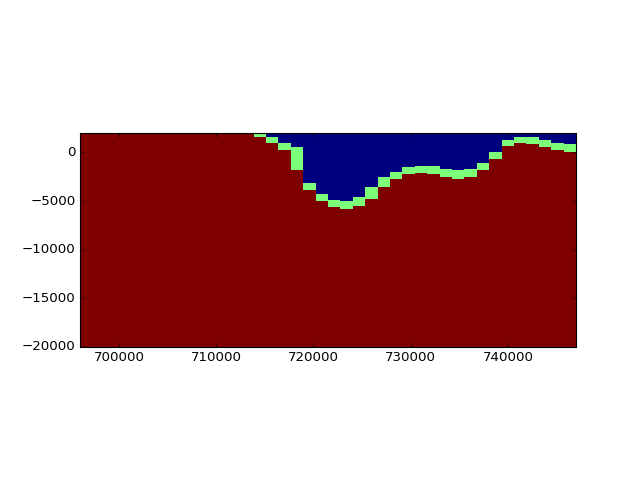

In [8]:
%matplotlib qt4
block = np.ones_like(sandstone.Z_x)
block[sandstone.Z_x>sandstone.potential_interfaces[0]] = 0
block[(sandstone.Z_x<sandstone.potential_interfaces[0]) * (sandstone.Z_x>sandstone.potential_interfaces[-1])] = 1
block[sandstone.Z_x<sandstone.potential_interfaces[-1]] = 2
block = block.reshape(40,40,150)
plt.imshow(block[:,13,:].T, origin = "bottom", aspect = "equal", extent = (sandstone.xmin, sandstone.xmax,
                                                                           sandstone.zmin, sandstone.zmax),
          interpolation = "none")

##  SImple mafic

The serie formations are SimpleMafic1


<IPython.core.display.Javascript object>


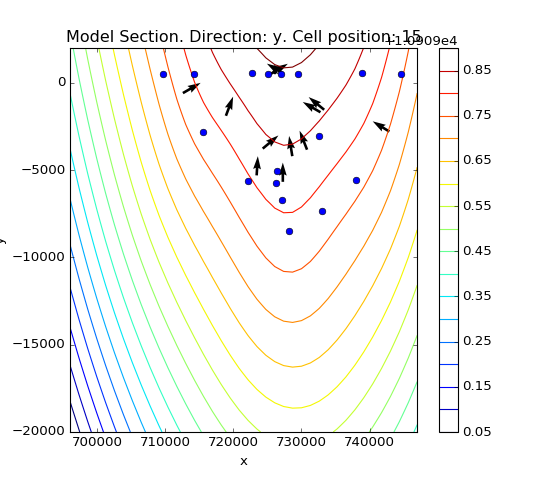

In [9]:
sandstone.compute_potential_field("SimpleMafic_Series", verbose = 1)
sandstone.plot_potential_field_2D(direction = "y", cell_pos = 15, figsize=(7,6), contour_lines = 20)

In [182]:
sandstone.potential_interfaces, sandstone.layers[0].shape;

<IPython.core.display.Javascript object>


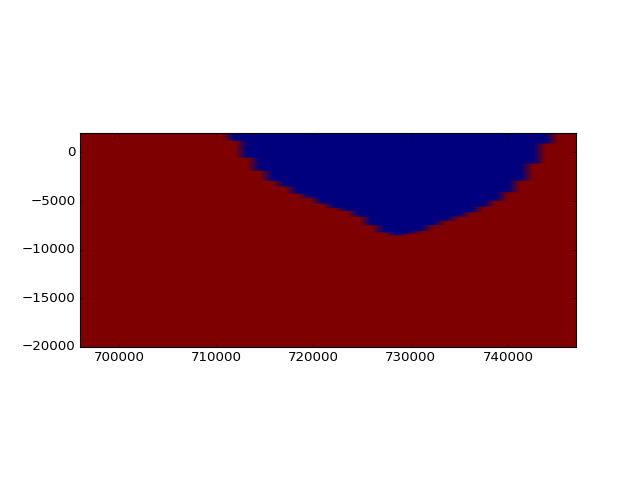

In [10]:
%matplotlib qt4
block = np.ones_like(sandstone.Z_x)
block[sandstone.Z_x>sandstone.potential_interfaces[0]] = 0
block[sandstone.Z_x<sandstone.potential_interfaces[-1]] = 1
block = block.reshape(40,40,150)
#block = np.swapaxes(block, 0, 1)
plt.imshow(block[:,13,:].T, origin = "bottom", aspect = "equal", extent = (sandstone.xmin, sandstone.xmax,
                                                                           sandstone.zmin, sandstone.zmax))

# Optimizing the export of lithologies

Here I am going to try to return from the theano interpolate function the internal type of the result (in this case DK I guess) so I can make another function in python I guess to decide which potential field I calculate at every grid_pos 

In [54]:
# Reset the block
sandstone.block.set_value(np.zeros_like(sandstone.grid[:,0]))

# Compute the block
sandstone.compute_block_model([0,1,2], verbose = 1)

4
[1 1 1 ..., 1 1 1] 0
The serie formations are EarlyGranite


ValueError: all the input array dimensions except for the concatenation axis must match exactly
Apply node that caused the error: Join(TensorConstant{1}, Reshape{2}.0, InplaceDimShuffle{1,0}.0)
Toposort index: 205
Inputs types: [TensorType(int8, scalar), TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(), (3, 720000), (9, 26)]
Inputs strides: [(), (5760000, 8), (8, 72)]
Inputs values: [array(1, dtype=int8), 'not shown', 'not shown']
Outputs clients: [[Subtensor{:int64:}(Join.0, ScalarFromTensor.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bl3/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bl3/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bl3/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-9f731ac4b8be>", line 12, in <module>
    sandstone.theano_compilation_3D()
  File "/home/bl3/PycharmProjects/GeMpy/GeMpy/GeoMig.py", line 355, in theano_compilation_3D
    universal_terms_layers)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

<IPython.core.display.Javascript object>


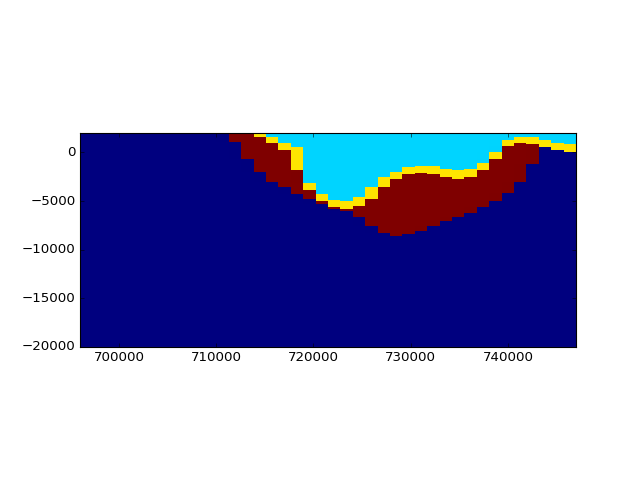

In [49]:
%matplotlib qt4

plot_block =  sandstone.block.get_value().reshape(40,40,150)
plt.imshow(plot_block[:,13,:].T, origin = "bottom", aspect = "equal",
           extent = (sandstone.xmin, sandstone.xmax, sandstone.zmin, sandstone.zmax), interpolation = "none")

# Export vtk

In [14]:
"""Export model to VTK

Export the geology blocks to VTK for visualisation of the entire 3-D model in an
external VTK viewer, e.g. Paraview.

..Note:: Requires pyevtk, available for free on: https://github.com/firedrakeproject/firedrake/tree/master/python/evtk

**Optional keywords**:
    - *vtk_filename* = string : filename of VTK file (default: output_name)
    - *data* = np.array : data array to export to VKT (default: entire block model)
"""
vtk_filename = "noddyFunct2"

extent_x = 10
extent_y = 10
extent_z = 10

delx = 0.2
dely = 0.2
delz = 0.2
from pyevtk.hl import gridToVTK
# Coordinates
x = np.arange(0, extent_x + 0.1*delx, delx, dtype='float64')
y = np.arange(0, extent_y + 0.1*dely, dely, dtype='float64')
z = np.arange(0, extent_z + 0.1*delz, delz, dtype='float64')

# self.block = np.swapaxes(self.block, 0, 2)
gridToVTK(vtk_filename, x, y, z, cellData = {"geology" : sol})

ImportError: No module named 'pyevtk'

# Performance Analysis

## CPU

In [32]:
%%timeit
sol =  interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0]

10 loops, best of 3: 46.8 ms per loop


In [172]:
sandstone.block_export.profile.summary()

Function profiling
  Message: /home/bl3/PycharmProjects/GeMpy/GeMpy/GeoMig.py:778
  Time in 12 calls to Function.__call__: 1.747251e+01s
  Time in Function.fn.__call__: 1.746418e+01s (99.952%)
  Time in thunks: 1.695012e+01s (97.010%)
  Total compile time: 8.084836e+00s
    Number of Apply nodes: 358
    Theano Optimizer time: 7.368957e+00s
       Theano validate time: 3.972366e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 4.228358e-01s
       Import time 0.000000e+00s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 4116.375s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  51.6%    51.6%       8.746s       6.57e-03s     C     1332     111   theano.tensor.elemwise.Elemwise
  21.5%    73.1%       3.647s       2.76e-02s     C      132      11   theano.tensor.basic.Alloc
   9.1%    82.2%       1.545s       4.29e-02s     Py      36       3   theano.tensor.basic.Nonzero
   6.9%    89.1%      

## GPU

In [23]:
interpolator.theano_set_3D()

/home/miguel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  if __name__ == '__main__':


In [26]:
%%timeit
sol =  interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0].reshape(20,20,20, order = "C")

10 loops, best of 3: 15 ms per loop


In [27]:
interpolator.geoMigueller.profile.summary()

Function profiling
  Message: /home/miguel/PycharmProjects/GeMpy/GeoMig.py:1313
  Time in 42 calls to Function.__call__: 7.134078e-01s
  Time in Function.fn.__call__: 7.101927e-01s (99.549%)
  Time in thunks: 5.815070e-01s (81.511%)
  Total compile time: 2.534589e+00s
    Number of Apply nodes: 290
    Theano Optimizer time: 2.050112e+00s
       Theano validate time: 1.564834e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 4.177537e-01s
       Import time 0.000000e+00s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 360.828s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  37.6%    37.6%       0.219s       1.93e-04s     C     1134      27   theano.tensor.elemwise.Elemwise
  16.2%    53.8%       0.094s       3.12e-05s     C     3024      72   theano.sandbox.cuda.basic_ops.GpuElemwise
  13.5%    67.3%       0.079s       1.87e-04s     C      420      10   theano.tensor.blas.Dot22Scalar
   9.5